In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# set style of visualization
sns.set_style("darkgrid")
sns.set_palette("RdBu")



In [3]:
pip install pyodbc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pyodbc
import pandas as pd

In [5]:
cnxn_str =("Driver={ODBC Driver 17 for SQL Server};"
                      "Server=LAPTOP-PU7MK2SG\IMAN;"
                      "Database=imanportfolio2;"
                      "Trusted_Connection=yes;")

In [6]:
cnxn = pyodbc.connect(cnxn_str)

In [7]:
cursor = cnxn.cursor()

In [9]:
query = """

with customer_stats as (
select customer_id, 
sum((list_price * quantity)*1-discount)total_spent,
max(order_date)last_order_date,
datediff(day, max(order_date), '2018-12-28')days_from_last_purchase,
count(distinct o.order_id)total_orders
from imanportfolio2..order_items oi
inner join imanportfolio2..orders o
on oi.order_id = o.order_id
group by customer_id
)

select customer_id, 
(case when total_orders > 1 then 'repeat buyer'
else 'one-time buyer' end )buying_frequency,

(case when days_from_last_purchase < 100 then 'recent buyer'
else 'not recent buyer' end )purchase_frequency,

(case when (total_spent/(select max(total_spent)from customer_stats)) > 0.7
then 'big spender'
when (total_spent/(select max(total_spent)from customer_stats)) < 0.4
then 'low spender'
else 'average spender'
end)buying_power
from customer_stats

"""

df = pd.read_sql_query(query, cnxn)
df

C:\Users\user\AppData\Local\Temp\ipykernel_7472\1703262157.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, cnxn)


,customer_id,buying_frequency,purchase_frequency,buying_power
0,1.0,repeat buyer,recent buyer,big spender
1,2.0,repeat buyer,not recent buyer,average spender
2,3.0,repeat buyer,recent buyer,average spender
3,4.0,repeat buyer,not recent buyer,average spender
4,5.0,repeat buyer,not recent buyer,average spender
...,...,...,...,...
1440,1441.0,one-time buyer,not recent buyer,low spender
1441,1442.0,one-time buyer,not recent buyer,low spender
1442,1443.0,one-time buyer,not recent buyer,low spender
1443,1444.0,one-time buyer,not recent buyer,low spender


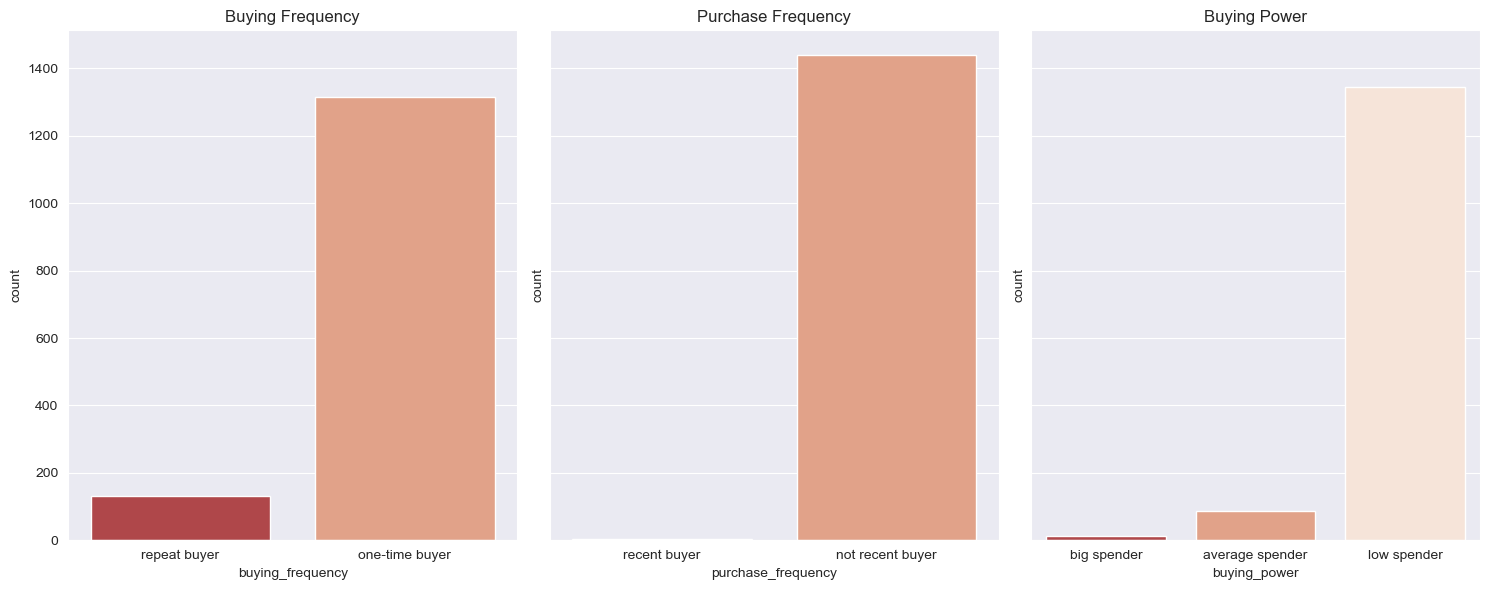

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6 ), sharey=True)

sns.countplot(x='buying_frequency', data=df, ax=ax[0])
ax[0].set_title('Buying Frequency')
sns.countplot(x='purchase_frequency', data=df, ax=ax[1])
ax[1].set_title('Purchase Frequency')
sns.countplot(x='buying_power', data=df, ax=ax[2])
ax[2].set_title('Buying Power')

plt.tight_layout()  
plt.show()

In [11]:
query = """

select product_name, round(rev, 0)revenue 
from (
select distinct p.product_name, 
sum(oi.list_price * oi.quantity * (1-oi.discount)) over(partition by p.product_name)rev 
from imanportfolio2..products p
join imanportfolio2..categories c
on p.category_id = c.category_id
join imanportfolio2..order_items oi
on oi.product_id= p.product_id
)subq
order by round(rev, 0) desc

"""


df = pd.read_sql_query(query, cnxn)
df


C:\Users\user\AppData\Local\Temp\ipykernel_7472\70099328.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, cnxn)


,product_name,revenue
0,Trek Slash 8 27.5 - 2016,555559.0
1,Trek Conduit+ - 2016,389249.0
2,Trek Fuel EX 8 29 - 2016,368473.0
3,Surly Straggler 650b - 2016,226766.0
4,Trek Domane SLR 6 Disc - 2017,211585.0
...,...,...
273,Trek Precaliber 24 7-speed Girl's - 2018,256.0
274,Electra Cruiser 1 Tall - 2016/2018,243.0
275,Trek MT 201 - 2018,225.0
276,Electra Soft Serve 1 (16-inch) - Girl's - 2018,224.0


[Text(0.5, 1.0, 'Top 20 Products')]

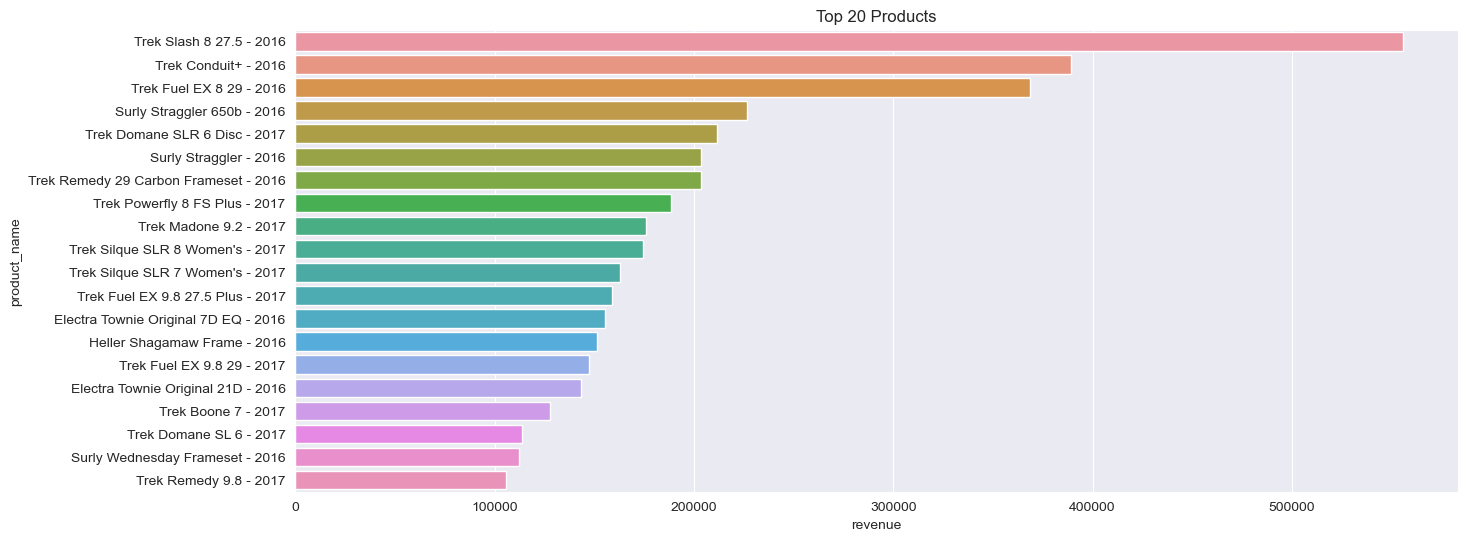

In [12]:
fig= plt.subplots(figsize=(15, 6))

sns.barplot(x='revenue', y='product_name', data=df.nlargest(20, 'revenue')).set(title='Top 20 Products')



In [13]:
query = """

 select month(order_date)month, round(sum(oi.list_price * oi.quantity * (1-oi.discount)),0)monthly_revenue
 from imanportfolio2..orders o
 join imanportfolio2..order_items oi
 on o.order_id = oi.order_id
 group by month(order_date)
 order by sum(oi.list_price * oi.quantity * (1-oi.discount))desc
 
 """

df= pd.read_sql_query(query, cnxn)
df

C:\Users\user\AppData\Local\Temp\ipykernel_7472\395561956.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df= pd.read_sql_query(query, cnxn)


,month,monthly_revenue
0,4,1212357.0
1,1,882193.0
2,3,853503.0
3,2,669694.0
4,6,589617.0
5,9,575461.0
6,10,526188.0
7,8,524589.0
8,11,475269.0
9,5,473503.0


<Axes: xlabel='month', ylabel='monthly_revenue'>

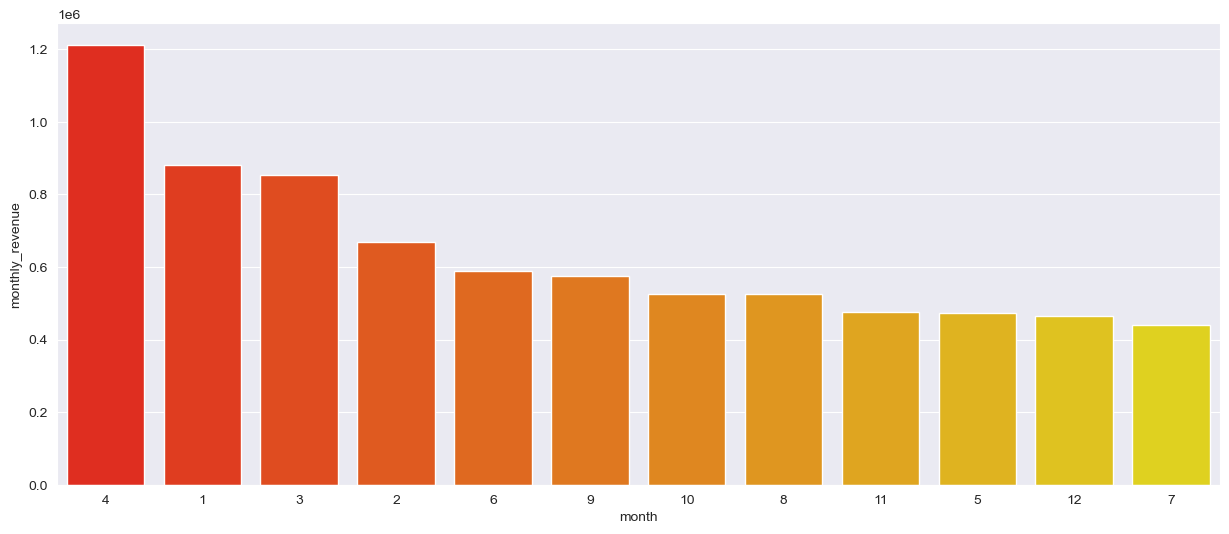

In [14]:


fig= plt.subplots(figsize=(15, 6))

sns.barplot(x='month', y="monthly_revenue", data=df, palette="autumn", 
            order=df.sort_values('monthly_revenue',ascending = False).month)




In [15]:
query = """

with product_categories as (
select product_id, category_name   
from imanportfolio2..categories c
join imanportfolio2..products p
on c.category_id = p.category_id 
),

monthly_orders as (
select product_id, month(order_date)month, year(order_date)year, sum(oi.quantity)units_sold
from imanportfolio2..orders o
join imanportfolio2..order_items oi
on o.order_id = oi.order_id
group by product_id, month(order_date), year(order_date)
) 

select month, category_name, round(avg(units_sold),1)avg_units_sold
from product_categories pc
inner join monthly_orders mo
on pc.product_id = mo.product_id
group by month, category_name
order by month, avg(units_sold)
 
 """

df=pd.read_sql_query(query, cnxn)
df



C:\Users\user\AppData\Local\Temp\ipykernel_7472\388045138.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql_query(query, cnxn)


,month,category_name,avg_units_sold
0,1,Road Bikes,2.1
1,1,Electric Bikes,2.7
2,1,Comfort Bicycles,2.8
3,1,Children Bicycles,3.0
4,1,Cruisers Bicycles,3.0
...,...,...,...
79,12,Comfort Bicycles,3.7
80,12,Children Bicycles,3.9
81,12,Cruisers Bicycles,5.0
82,12,Electric Bikes,5.8


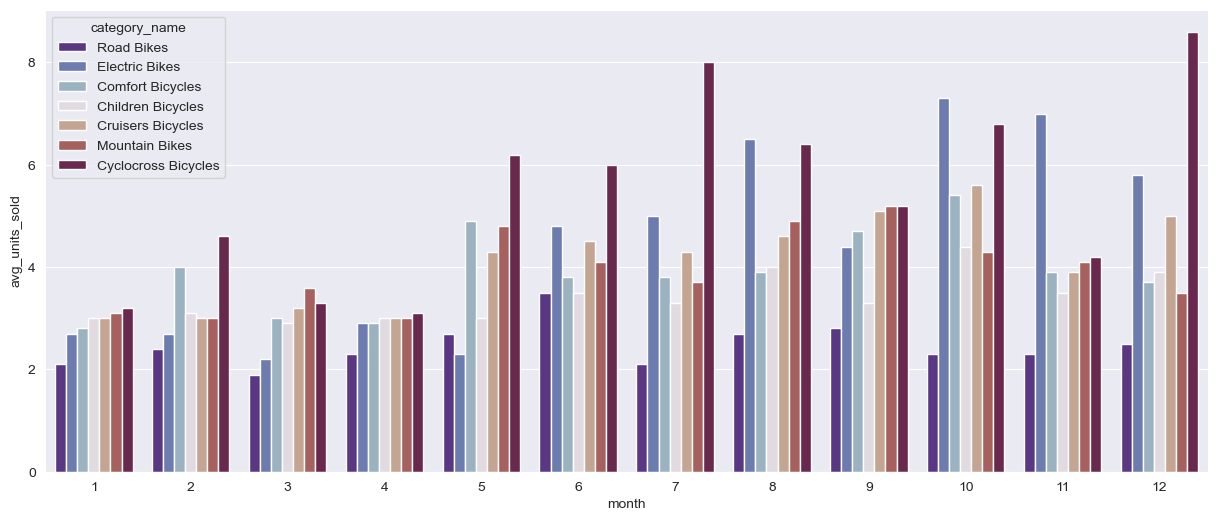

In [16]:
fig= plt.subplots(figsize=(15, 6))


graph= sns.barplot(x='month',y='avg_units_sold', hue='category_name', data=df, palette='twilight_shifted')



In [17]:
query = """

select product_a, product_b, purchase_count 
from (
select p1.product_name as product_a, p2.product_name as product_b, count(*)purchase_count
from imanportfolio2..order_items oi1
inner join imanportfolio2..order_items oi2
on oi1.order_id = oi2.order_id and 
oi1.product_id <> oi2.product_id 
inner join imanportfolio2..products p1
on p1.product_id = oi1.product_id
inner join imanportfolio2..products p2
on p2.product_id = oi2.product_id
group by p1.product_id, p2.product_id, p1.product_name, p2.product_name) subq
order by purchase_count desc

"""

df=pd.read_sql_query(query, cnxn)
df

C:\Users\user\AppData\Local\Temp\ipykernel_7472\1183214974.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql_query(query, cnxn)


,product_a,product_b,purchase_count
0,Electra Girl's Hawaii 1 (16-inch) - 2015/2016,Heller Shagamaw Frame - 2016,15
1,Heller Shagamaw Frame - 2016,Electra Girl's Hawaii 1 (16-inch) - 2015/2016,15
2,Electra Townie Original 21D - 2016,Electra Cruiser 1 (24-Inch) - 2016,14
3,Electra Cruiser 1 (24-Inch) - 2016,Electra Townie Original 21D - 2016,14
4,Electra Cruiser 1 (24-Inch) - 2016,Electra Moto 1 - 2016,14
...,...,...,...
6923,Electra Townie 7D (20-inch) - Boys' - 2017,Electra Cruiser 1 (24-Inch) - 2016,1
6924,Sun Bicycles Streamway - 2017,Electra Cruiser 1 (24-Inch) - 2016,1
6925,Trek Domane SL Frameset Women's - 2018,Electra Cruiser 1 (24-Inch) - 2016,1
6926,Trek Conduit+ - 2018,Electra Cruiser 1 (24-Inch) - 2016,1
